In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
from ta.volatility import AverageTrueRange, BollingerBands
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:


data_dir = 'ohlc_data'
symbols = ['EURUSD', 'AUDUSD', 'GBPUSD']

for i in symbols:
    data_path = os.path.join(os.getcwd(), data_dir, i, 'H1_'+i+'_2015.csv')
    print(data_path)
    dt = pd.read_csv(data_path, index_col=0)
    
    # Convert Unix timestamps to datetime format
    dt['Date'] = pd.to_datetime(dt['time'], unit='s')
    
    if 'volume' not in dt.columns:
        dt.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'tick_volume':'Volume'}, inplace=True)
    else:
        dt.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)

#     data = pd.read_csv(data_path, parse_dates=["Date"], index_col="Date")
    break

raw_data = dt


D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\H1_EURUSD_2015.csv


In [15]:
raw_data

time     Open     High      Low    Close  Volume  spread   
0      1420048800  1.20997  1.21089  1.20966  1.20999    3237      17  \
1      1420185600  1.20481  1.20569  1.20479  1.20538    1254      17   
2      1420189200  1.20537  1.20574  1.20341  1.20553    3394      17   
3      1420192800  1.20556  1.20689  1.20442  1.20469    4590      17   
4      1420196400  1.20468  1.20599  1.20380  1.20573    4335      17   
...           ...      ...      ...      ...      ...     ...     ...   
61933  1734688800  1.03816  1.03974  1.03770  1.03913    5104      17   
61934  1734692400  1.03913  1.03915  1.03749  1.03817    4389      17   
61935  1734696000  1.03818  1.03921  1.03803  1.03908    3521      17   
61936  1734699600  1.03908  1.03964  1.03785  1.03906    3663      17   
61937  1734703200  1.03906  1.03992  1.03869  1.03885    3749      17   

       real_volume                Date  
0                0 2014-12-31 18:00:00  
1                0 2015-01-02 08:00:00  
2                0 2015-01-02 09:00:00  
3                0 2015-01-02 10:00:00  
4                0 2015-01-02 11:00:00  
...            ...                 ...  
61933            0 2024-12-20 10:00:00  
61934            0 2024-12-20 11:00:00  
61935            0 2024-12-20 12:00:00  
61936            0 2024-12-20 13:00:00  
61937            0 2024-12-20 14:00:00  

[61938 rows x 9 columns]

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

# --- Generate extrema signals ---
def generate_signal_only_extrema(df, cluster_length=30):
    df = df.copy()
    
    # Identify local maxima and minima
    max_signal_indices = argrelextrema(df['Close'].values, np.greater, order=cluster_length)[0]
    min_signal_indices = argrelextrema(df['Close'].values, np.less, order=cluster_length)[0]

    # Initialize Signal column
    df['Signal'] = 0
    df.loc[max_signal_indices, 'Signal'] = -1  # Sell Signal
    df.loc[min_signal_indices, 'Signal'] = 1   # Buy Signal
    
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    return df

# --- Backtest simple next-day returns ---
def backtest_signal(df):
    df = df.copy()
    df['Return'] = df['Close'].pct_change().shift(-1)  # Next day's return
    df['StrategyReturn'] = df['Signal'] * df['Return']
    total_return = df['StrategyReturn'].sum()
    return total_return

# --- Test different cluster sizes and plot ---
def test_cluster_sizes_with_plot(csv_data, cluster_range=range(5, 101, 5)):
    results = []
    
    for cluster_len in cluster_range:
        df_signals = generate_signal_only_extrema(csv_data, cluster_length=cluster_len)
        total_return = backtest_signal(df_signals)
        results.append({'ClusterLength': cluster_len, 'TotalReturn': total_return})
    
    results_df = pd.DataFrame(results)
    
    # Find best cluster length (max total return, least negative)
    best_row = results_df.loc[results_df['TotalReturn'].idxmax()]
    
    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(results_df['ClusterLength'], results_df['TotalReturn'], marker='o', color='blue', label='Total Return')
    plt.scatter(best_row['ClusterLength'], best_row['TotalReturn'], color='red', s=100, label=f'Best: {best_row["ClusterLength"]}')
    plt.title('Total Return vs Cluster Length')
    plt.xlabel('Cluster Length')
    plt.ylabel('Total Return')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print(f"Best Cluster Length: {best_row['ClusterLength']} with Total Return: {best_row['TotalReturn']:.4f}")
    
    return results_df

# --- Example usage ---
# df = pd.read_csv('your_file.csv')
# results_df = test_cluster_sizes_with_plot(df)
# print(results_df)


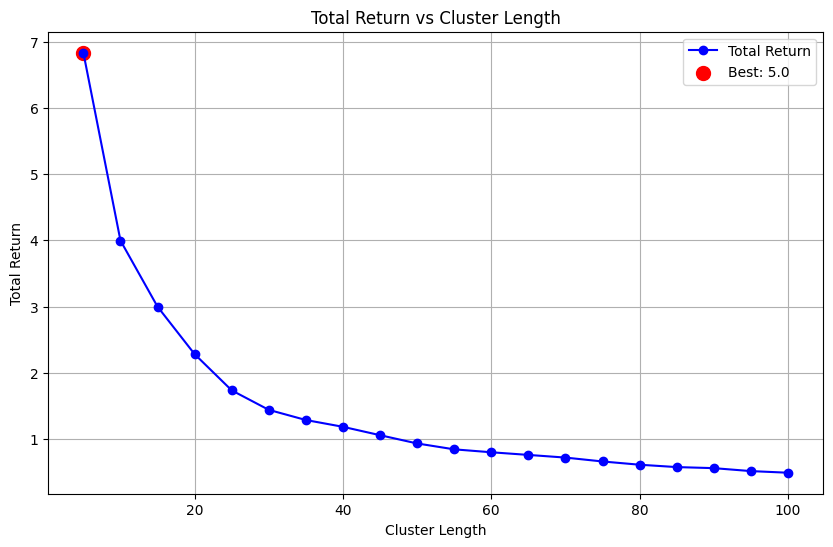

Best Cluster Length: 5.0 with Total Return: 6.8327
    ClusterLength  TotalReturn
0               5     6.832651
1              10     3.996199
2              15     2.997553
3              20     2.280610
4              25     1.733865
5              30     1.439614
6              35     1.286186
7              40     1.183659
8              45     1.057028
9              50     0.932234
10             55     0.843361
11             60     0.799080
12             65     0.759148
13             70     0.718856
14             75     0.660136
15             80     0.611102
16             85     0.575407
17             90     0.559417
18             95     0.514912
19            100     0.490250


In [8]:
# Example usage:
results_df = test_cluster_sizes_with_plot(raw_data)
print(results_df)

In [16]:
def generate_signal(csv_data, propagate=False, reset_length=5, atr_threshold_percent=25):
    df=csv_data.copy()

    cluster_length = 30
    start = 0
    end = len(dt)
    # end = 5000
    # Assuming 'df' is your DataFrame and it contains 'Date' and 'Close' columns
    df = df.iloc[start:end].reset_index(drop=True)  # Reset index after slicing

    # Identify local maxima and minima
    max_signal_indices = argrelextrema(df['Close'].values, np.greater, order=cluster_length)[0]
    min_signal_indices = argrelextrema(df['Close'].values, np.less, order=cluster_length)[0]

    # Initialize Signal column
    df['Signal'] = 0
    df.loc[max_signal_indices, 'Signal'] = -1  # Sell Signal
    df.loc[min_signal_indices, 'Signal'] = 1   # Buy Signal
    
    # Assuming df is your pandas DataFrame with datetime already parsed
    df['Date'] = pd.to_datetime(df['Date'])  # Make sure Date is datetime
    df.set_index('Date', inplace=True)


    # Debugging Info
    print(f"Total Sell Signals from argrelextrema: {len(max_signal_indices)}")
    print(f"Total Original Buy Signals from argrelextrema: {len(min_signal_indices)}")
    print(f"Filtered Signals After Extension: {df['Signal'].value_counts()}")
    
    #     To filter out consecutive duplicate buy or sell signals that occur within a short distance (e.g., 25 candles), 
    #     (e.g., both Buy = 1 or both Sell = -1) occur within 25 rows, remove (nullify) the second one


    Threshold_distance = 25

    # Get all signal indices (timestamps)
    signal_indices = df[df['Signal'] != 0].index

    # Loop through signal indices
    for i in range(1, len(signal_indices)):
        current_ts = signal_indices[i]
        prev_ts = signal_indices[i - 1]

        # Get integer row positions of those timestamps
        current_pos = df.index.get_loc(current_ts)
        prev_pos = df.index.get_loc(prev_ts)

        # Compare row distance and check if signal is repeated
        if (current_pos - prev_pos) <= Threshold_distance and \
           df.loc[current_ts, 'Signal'] == df.loc[prev_ts, 'Signal']:
            df.loc[current_ts, 'Signal'] = 0  # Nullify duplicate signal

    # Debugging Info
    print(f"Filtered Signals 2 BUY/SELL within {Threshold_distance} Distance: {df['Signal'].value_counts()}")
    
    
    # Adding delay (shift forward) each signal by 3 steps, meaning:
    # A Buy/Sell signal at time t will instead appear at time t+3
    # The original position (t) becomes a Hold (0)

    extension_length = 3
    # Create a copy to avoid modifying while iterating
    original_signals = df['Signal'].copy()

    # Reset all current signals
    df['Signal'] = 0

    # Shift each signal forward by `extension_length`
    for idx in original_signals[original_signals != 0].index:
        new_idx_pos = df.index.get_loc(idx) + extension_length

        if new_idx_pos < len(df):
            new_idx = df.index[new_idx_pos]
            df.loc[new_idx, 'Signal'] = original_signals.loc[idx]  # Assign signal after delay
        # else: it's near the end — skip to avoid IndexError
        
    if propagate:
        # df = filter_signals_by_future_slope(df, look_ahead=24, slope_threshold=0)
        df = signal_propagate(df, propagate)
        df = prior_signal_making_zero(df, reset_length)                
        df = remove_low_volatility_signals(df, atr_threshold_percent, atr_period=14)        
        # Optional: Bollinger squeeze filter
        # df = remove_bollinger_squeeze_signals(df, squeeze_percentile=20, bb_period=20, bb_std=2)        
        return df
    else:
        return df

# Propagate signals consecutively
def signal_propagate(df_signals, propagate):
    df = df_signals.copy()
    current_signal = 0
    for idx in df.index:
        if df.loc[idx, 'Signal'] != 0:
            current_signal = df.loc[idx, 'Signal']  # Update the current signal
        df.loc[idx, 'Signal'] = current_signal  # Propagate the current signal
    # Debugging Info
    print(f"Filtered Signals After Propagation: {df['Signal'].value_counts()}")
    return df

def prior_signal_making_zero(df_signal, reset_length=5):
    df = df_signal.copy()
    reset_indexes = set()

    for i in range(1, len(df)):
        if (df.iloc[i]['Signal'] == 1 and df.iloc[i-1]['Signal'] == -1) or \
           (df.iloc[i]['Signal'] == -1 and df.iloc[i-1]['Signal'] == 1):
            for j in range(i, i - reset_length - 1, -1):
                if j >= 0:
                    reset_indexes.add(j)

    df.iloc[list(reset_indexes), df.columns.get_loc('Signal')] = 0
    print(f"After nullify prior {reset_length} signal: {df['Signal'].value_counts()}")
    return df


def filter_signals_by_future_slope(df, look_ahead=24, slope_threshold=0):
    """
    Nullifies Buy/Sell signals if the future slope over `look_ahead` bars
    does not align with the signal direction.

    Parameters:
        df (DataFrame): Must have 'Close' and 'Signal' columns, indexed by datetime.
        look_ahead (int): Number of future bars to check.
        slope_threshold (float): Minimum slope magnitude to keep a signal.
                                 Positive for Buy, Negative for Sell.
    Returns:
        DataFrame with adjusted 'Signal' column.
    """
    df = df.copy()
    lr = LinearRegression()

    # Get all indices with signals
    signal_indices = df[df['Signal'] != 0].index.tolist()

    for idx in signal_indices:
        pos = df.index.get_loc(idx)

        # Ensure there are enough future rows
        if pos + look_ahead < len(df):
            y = df['Close'].iloc[pos:pos + look_ahead].values.reshape(-1, 1)
            x = np.arange(len(y)).reshape(-1, 1)

            # Fit linear regression
            lr.fit(x, y)
            slope = lr.coef_[0][0] if lr.coef_.ndim > 1 else lr.coef_[0]

            # Buy signal but slope not positive enough
            if df.loc[idx, 'Signal'] == 1 and slope <= slope_threshold:
                df.loc[idx, 'Signal'] = 0

            # Sell signal but slope not negative enough
            elif df.loc[idx, 'Signal'] == -1 and slope >= -slope_threshold:
                df.loc[idx, 'Signal'] = 0

    print(f"Signals after future-slope filter: {df['Signal'].value_counts()}")
    return df



def remove_low_volatility_signals(df, threshold_percentile=20, atr_period=14):
    """
    Set signals to 0 when ATR is below a certain percentile threshold (low volatility).
    """
    df = df.copy()

    # Check required columns
    for col in ['High', 'Low', 'Close', 'Signal']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Calculate ATR
    atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=atr_period)
    df['ATR'] = atr.average_true_range()

    # Calculate volatility threshold
    atr_threshold = df['ATR'].quantile(threshold_percentile / 100)

    # Mask: where ATR is too low, nullify the signal
    low_volatility = df['ATR'] < atr_threshold
    df.loc[low_volatility, 'Signal'] = 0

    print(f"Low-volatility threshold (ATR percentile {threshold_percentile}%) = {atr_threshold:.6f}")
    print(f"After nullify prior signal: {df['Signal'].value_counts()}")
    return df


def remove_bollinger_squeeze_signals(df, squeeze_percentile=20, bb_period=20, bb_std=2):
    """
    Set signals to 0 when Bollinger Band Width is below a given percentile threshold (squeeze condition).
    
    Parameters:
        df (DataFrame): Must contain 'Close' and 'Signal'
        squeeze_percentile (float): Percentile threshold to detect squeezes (0-100)
        bb_period (int): Bollinger Band lookback period
        bb_std (float): Standard deviation multiplier for bands
    """
    df = df.copy()

    # Ensure required columns
    for col in ['Close', 'Signal']:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Calculate Bollinger Bands
    bb = BollingerBands(close=df['Close'], window=bb_period, window_dev=bb_std)
    df['bb_mavg'] = bb.bollinger_mavg()
    df['bb_high'] = bb.bollinger_hband()
    df['bb_low'] = bb.bollinger_lband()

    # Calculate Band Width
    df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mavg']

    # Determine squeeze threshold
    squeeze_threshold = df['bb_width'].quantile(squeeze_percentile / 100)

    # Mask signals where squeeze occurs
    squeeze_mask = df['bb_width'] < squeeze_threshold
    df.loc[squeeze_mask, 'Signal'] = 0

    print(f"Bollinger Squeeze threshold (width < {squeeze_threshold:.6f}) applied.")
    print(f"Signals after squeeze filter: {df['Signal'].value_counts()}")
    return df


In [13]:
df = generate_signal(raw_data, True, atr_threshold_percent=35, reset_length=5)

Total Sell Signals from argrelextrema: 635
Total Original Buy Signals from argrelextrema: 635
Filtered Signals After Extension: Signal
 0    60668
 1      635
-1      635
Name: count, dtype: int64
Filtered Signals 2 BUY/SELL within 25 Distance: Signal
 0    60668
 1      635
-1      635
Name: count, dtype: int64
Filtered Signals After Propagation: Signal
 1    31128
-1    30706
 0      104
Name: count, dtype: int64
After nullify prior 5 signal: Signal
 1    27993
-1    27571
 0     6374
Name: count, dtype: int64


In [10]:
def generate_plot(data_plot, val_limit=5000):
    df = data_plot.iloc[:val_limit, :].copy()
    # Plot Close Prices and signals
    plt.figure(figsize=(12, 7))
    plt.plot(df.index, df['Close'], c='gray', alpha=0.7, label='Close Price', linewidth=1)
    # plt.plot(df.index, df['Lower_Band'], c='red', alpha=0.7, label='Lower_Band', linewidth=1)
    # plt.plot(df.index, df['Upper_Band'], c='blue', alpha=0.7, label='Upper_Band', linewidth=1)

    # Combine Buy and Sell Signals
    signals = df[df['Signal'] != 0]

    # Plot Sell Signals
    sell_signals = signals[signals['Signal'] == -1]
    plt.scatter(sell_signals.index, sell_signals['Close'], c='red', label='Sell Signal', marker='o', s=4)

    # Plot Buy Signals
    buy_signals = signals[signals['Signal'] == 1]
    plt.scatter(buy_signals.index, buy_signals['Close'], c='blue', label='Buy Signal', marker='o', s=4)

    # Chart Customization
    plt.title('Buy/Sell Signals on Close Price', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title='Signal Type')
    plt.tight_layout()
    plt.show()


import matplotlib.dates as mdates

def generate_plot_date_range(data_plot, start_date=None, end_date=None, tick_interval='5D'):
    df = data_plot.copy()
    
    # Filter by date range if provided
    if start_date and end_date:
        df = df.loc[start_date:end_date]

    plt.figure(figsize=(12, 7))
    plt.plot(df.index, df['Close'], c='gray', alpha=0.7, label='Close Price', linewidth=1)

    # Combine Buy and Sell Signals
    signals = df[df['Signal'] != 0]

    # Plot Sell Signals
    sell_signals = signals[signals['Signal'] == -1]
    plt.scatter(sell_signals.index, sell_signals['Close'], c='red', label='Sell Signal', marker='o', s=10)

    # Plot Buy Signals
    buy_signals = signals[signals['Signal'] == 1]
    plt.scatter(buy_signals.index, buy_signals['Close'], c='blue', label='Buy Signal', marker='o', s=10)

    # Customize date labels on x-axis
    ax = plt.gca()

    # Parse tick interval and set locator
    if tick_interval.endswith('D'):
        days = int(tick_interval[:-1])
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=days))
    elif tick_interval.endswith('M'):
        months = int(tick_interval[:-1])
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=months))
    elif tick_interval.endswith('Y'):
        years = int(tick_interval[:-1])
        ax.xaxis.set_major_locator(mdates.YearLocator(base=years))
    else:
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # fallback

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=60, fontsize=10)

    plt.title('Buy/Sell Signals on Close Price', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(title='Signal Type')
    plt.tight_layout()
    plt.show()


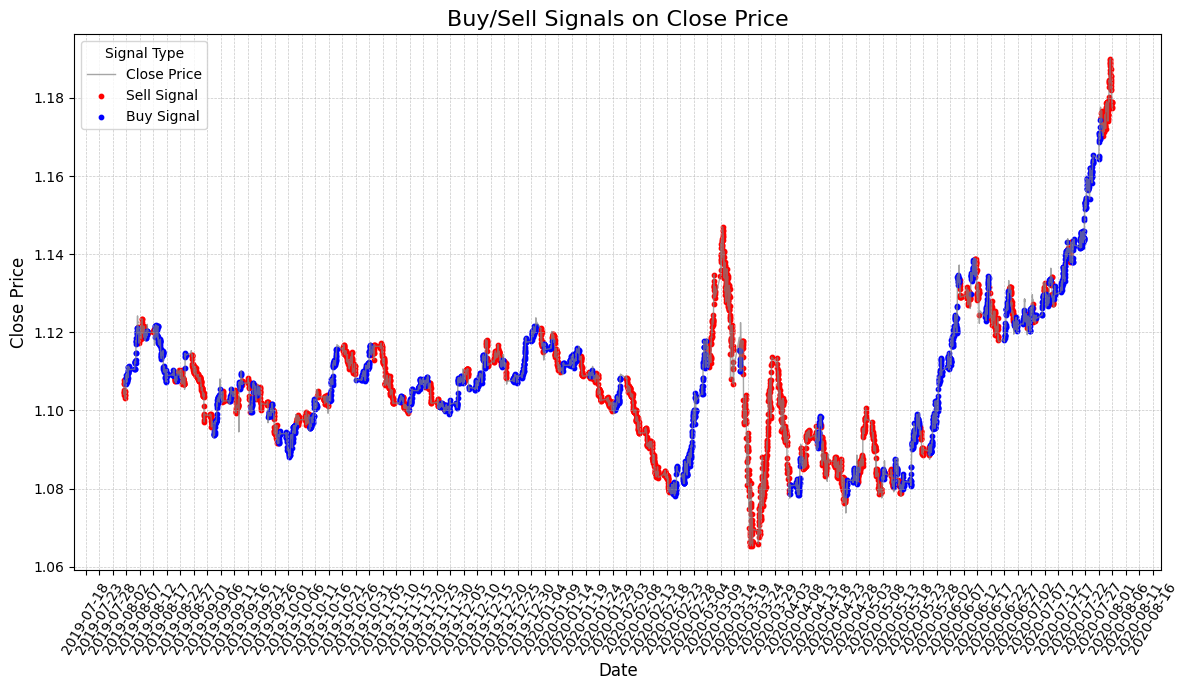

In [14]:
# Every 5 days
generate_plot_date_range(df, '2019-08-01', '2020-07-31', tick_interval='5D')

# # Every 1 month
# generate_plot_date_range(data_plot, '2019-08-01', '2020-07-31', tick_interval='1M')

# # Every 15 days
# generate_plot_date_range(data_plot, '2019-08-01', '2020-07-31', tick_interval='15D')


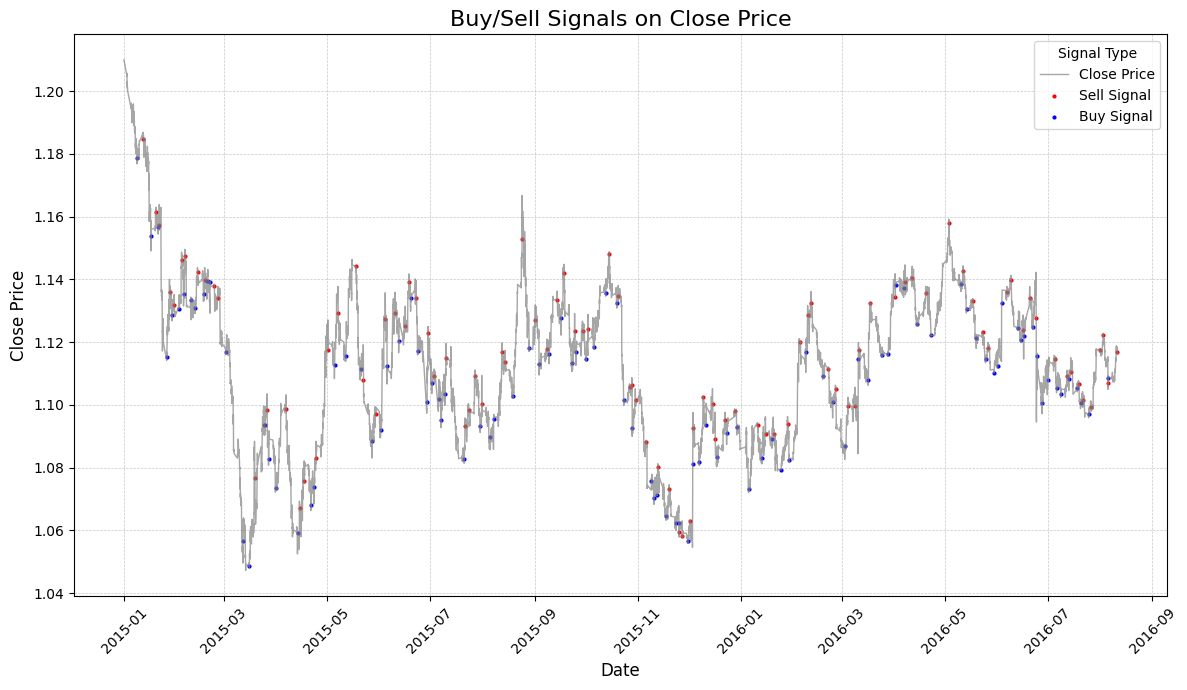

In [19]:
generate_plot(df, val_limit=10000)

In [20]:
df.to_csv('Cleaned_Signal_EURUSD_for_training_635_635_60000.csv')

In [13]:
df.loc['2020-02-23':'2020-03-04'].query("Signal != 0")['Signal']

Date
2020-03-03 23:00:00   -1
Name: Signal, dtype: int64

In [15]:
df.loc['2015-04':'2015-05'].query("Signal != 0")['Signal']

Date
2015-04-06 20:00:00   -1
2015-04-13 16:00:00    1
2015-04-14 20:00:00   -1
2015-04-17 15:00:00   -1
2015-04-21 13:00:00    1
2015-04-23 13:00:00    1
2015-04-24 14:00:00   -1
2015-05-01 19:00:00   -1
2015-05-05 13:00:00    1
2015-05-07 15:00:00   -1
2015-05-12 06:00:00    1
2015-05-18 00:00:00   -1
2015-05-20 21:00:00    1
2015-05-22 15:00:00   -1
2015-05-27 18:00:00    1
2015-05-29 19:00:00   -1
Name: Signal, dtype: int64

In [26]:
df.loc['2020-03-03', 'Signal'] = 0
df.loc['2020-02-18', 'Signal'] = 1

# Manual Labeling
df.loc['2015-03-02 04:00:00', 'Signal'] = 0
df.loc['2015-04-24 14:00:00', 'Signal'] = 0

In [ ]:
df = signal_propagate(df, propagate=True)
df = prior_signal_making_zero(df, reset_length=7)                
df = remove_low_volatility_signals(df, threshold_percentile=35, atr_period=14)        
df.to_csv('Cleaned_Signal_EURUSD_for_training.csv')        

Filtered Signals After Propagation: Signal
 1    31194
-1    30640
 0      104
Name: count, dtype: int64


In [12]:
import backtrader as bt
import datetime


In [34]:
class CustomPandasFeed(bt.feeds.PandasData):
    lines = ('signal',)
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', -1),
        ('signal', 'Signal'),
#         ('moving_avg', 'Moving_Avg'),
#         ('upper_band', 'Upper_Band'),
#         ('lower_band', 'Lower_Band'),
    )

class SignalBandStrategy(bt.Strategy):
    def __init__(self):
        self.last_signal = 0  # Initialize to no position

    def next(self):
        signal = self.data.signal[0]  # Access the signal from the custom data

        if signal == 0:
            return  # Hold, do nothing

        if signal != self.last_signal:
            # Close existing position before switching
            if self.position:
                self.close()
            
            # Open new position based on signal
            if signal == 1:
                self.buy()
            elif signal == -1:
                self.sell()

            # Update last_signal to current
            self.last_signal = signal

In [36]:
data = CustomPandasFeed(dataname=df)

Starting Portfolio Value: 10000.00
Final Portfolio Value: 11281.02


<IPython.core.display.Javascript object>


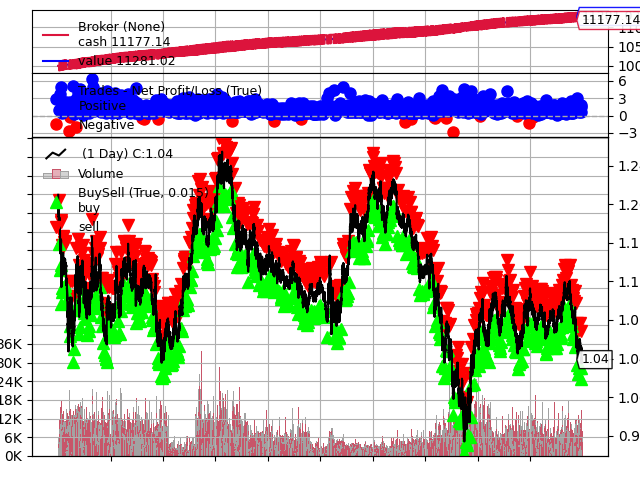

[[<Figure size 640x480 with 4 Axes>]]

In [37]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(SignalBandStrategy)
cerebro.broker.set_cash(10000)
cerebro.addsizer(bt.sizers.FixedSize, stake=100)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
results = cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.plot()


In [39]:
# ------------------- Step 4: Initialize Cerebro -------------------
cerebro = bt.Cerebro()
data = CustomPandasFeed(dataname=df)
cerebro.adddata(data)
cerebro.addstrategy(SignalBandStrategy)

# Initial cash
cerebro.broker.setcash(10000)
cerebro.addsizer(bt.sizers.FixedSize, stake=100)

# ------------------- Step 5: Add Analyzers -------------------
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

# ------------------- Step 6: Run and Analyze -------------------
results = cerebro.run()
strategy = results[0]
# ------------------- Step 7: Plot -------------------
cerebro.plot()



strat = results[0]  # Get the strategy instance

# ----- Sharpe Ratio -----
sharpe = strat.analyzers.sharpe.get_analysis()
print(f"\nSharpe Ratio: {sharpe.get('sharperatio', 'N/A')}")

# ----- Drawdown -----
drawdown = strat.analyzers.drawdown.get_analysis()
print("\nDrawdown Summary:")
print(f"Current Drawdown (%): {drawdown['drawdown'] * 100:.2f}%")
print(f"Current Drawdown ($): ${drawdown['moneydown']:.4f}")
print(f"Max Drawdown (%): {drawdown['max']['drawdown'] * 100:.2f}%")
print(f"Max Drawdown ($): ${drawdown['max']['moneydown']:.4f}")
print(f"Max Duration (bars): {drawdown['max']['len']}")
print(f"Current Duration (bars): {drawdown['len']}")

# ----- Trade Summary -----
trades = strat.analyzers.trades.get_analysis()
print("\nTrade Summary:")
print(f"Total Trades: {trades.total.total}")
print(f"Closed Trades: {trades.total.closed}")
print(f"Open Trades: {trades.total.open}")
print(f"Long Trades: {trades.long.total}")
print(f"Short Trades: {trades.short.total}")

# ----- Streaks -----
print("\nStreaks:")
print(f"Winning Streak (Current): {trades.streak.won.current}")
print(f"Winning Streak (Longest): {trades.streak.won.longest}")
print(f"Losing Streak (Current): {trades.streak.lost.current}")
print(f"Losing Streak (Longest): {trades.streak.lost.longest}")

# ----- Profit & Loss -----
print("\nPnL Summary:")
print(f"Gross Total PnL: {trades.pnl.gross.total:.4f}")
print(f"Gross Average PnL: {trades.pnl.gross.average:.4f}")
print(f"Net Total PnL: {trades.pnl.net.total:.4f}")
print(f"Net Average PnL: {trades.pnl.net.average:.4f}")

# ----- Win/Loss Breakdown -----
print("\nWin/Loss Breakdown:")
print(f"Winning Trades: {trades.won.total}")
print(f"  Total Win PnL: {trades.won.pnl.total:.4f}")
print(f"  Average Win PnL: {trades.won.pnl.average:.4f}")
print(f"  Max Win PnL: {trades.won.pnl.max:.4f}")

print(f"Losing Trades: {trades.lost.total}")
print(f"  Total Loss PnL: {trades.lost.pnl.total:.4f}")
print(f"  Average Loss PnL: {trades.lost.pnl.average:.4f}")
print(f"  Max Loss PnL: {trades.lost.pnl.max:.4f}")

# ----- Returns -----
returns = strat.analyzers.returns.get_analysis()
print("\nReturns Summary:")
print(f"Total Return: {returns.get('rtot', 0):.4f}")
print(f"Average Return: {returns.get('ravg', 0):.4f}")
print(f"Standard Deviation: {returns.get('rstd', 0):.4f}")
print(f"Final Value: {returns.get('rnorm', 0):.4f}")
print(f"Best Period Return: {returns.get('rnorm100', 0):.4f}")
print(f"Positive Return %: {returns.get('positive', 0):.2%}")
print(f"Negative Return %: {returns.get('negative', 0):.2%}")


Sharpe Ratio: 0.232262447700294

Drawdown Summary:
Current Drawdown (%): 0.20%
Current Drawdown ($): $0.2290
Max Drawdown (%): 7.48%
Max Drawdown ($): $7.5110
Max Duration (bars): 452
Current Duration (bars): 27

Trade Summary:
Total Trades: 1049
Closed Trades: 1048
Open Trades: 1
Long Trades: 524
Short Trades: 524

Streaks:
Winning Streak (Current): 107
Winning Streak (Longest): 191
Losing Streak (Current): 0
Losing Streak (Longest): 2

PnL Summary:
Gross Total PnL: 1280.6250
Gross Average PnL: 1.2220
Net Total PnL: 1280.6250
Net Average PnL: 1.2220

Win/Loss Breakdown:
Winning Trades: 1029
  Total Win PnL: 1297.3770
  Average Win PnL: 1.2608
  Max Win PnL: 6.3930
Losing Trades: 19
  Total Loss PnL: -16.7520
  Average Loss PnL: -0.8817
  Max Loss PnL: -2.8270

Returns Summary:
Total Return: 0.1205
Average Return: 0.0000
Standard Deviation: 0.0000
Final Value: 0.0117
Best Period Return: 1.1675
Positive Return %: 0.00%
Negative Return %: 0.00%


<IPython.core.display.Javascript object>


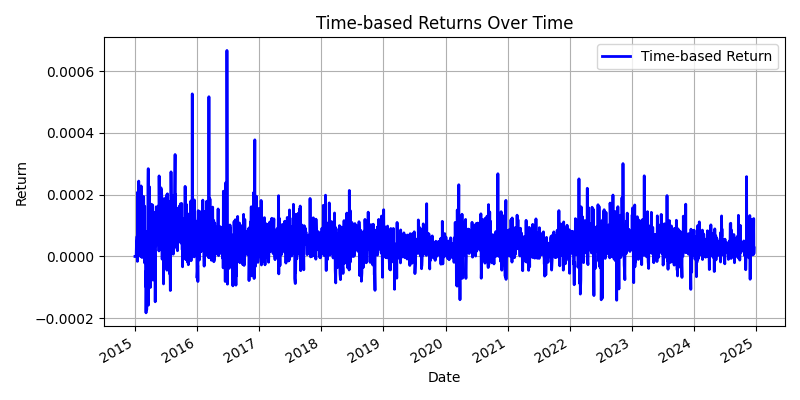

In [40]:
timereturn = strat.analyzers.timereturn.get_analysis()
# Convert the ordered dict to a pandas Series
time_return_series = pd.Series(timereturn)

# Plot
plt.figure(figsize=(8, 4))
time_return_series.plot(label='Time-based Return', color='blue', lw=2)
plt.title('Time-based Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
data_signal = df
data_signal.index = pd.to_datetime(data_signal.index)
data_signal 

time     Open     High      Low    Close  Volume   
Date                                                                          
2014-12-31 18:00:00  1420048800  1.20997  1.21089  1.20966  1.20999    3237  \
2015-01-02 08:00:00  1420185600  1.20481  1.20569  1.20479  1.20538    1254   
2015-01-02 09:00:00  1420189200  1.20537  1.20574  1.20341  1.20553    3394   
2015-01-02 10:00:00  1420192800  1.20556  1.20689  1.20442  1.20469    4590   
2015-01-02 11:00:00  1420196400  1.20468  1.20599  1.20380  1.20573    4335   
...                         ...      ...      ...      ...      ...     ...   
2024-12-20 10:00:00  1734688800  1.03816  1.03974  1.03770  1.03913    5104   
2024-12-20 11:00:00  1734692400  1.03913  1.03915  1.03749  1.03817    4389   
2024-12-20 12:00:00  1734696000  1.03818  1.03921  1.03803  1.03908    3521   
2024-12-20 13:00:00  1734699600  1.03908  1.03964  1.03785  1.03906    3663   
2024-12-20 14:00:00  1734703200  1.03906  1.03992  1.03869  1.03885    3749   

                     spread  real_volume  Signal  
Date                                              
2014-12-31 18:00:00      17            0       0  
2015-01-02 08:00:00      17            0       0  
2015-01-02 09:00:00      17            0       0  
2015-01-02 10:00:00      17            0       0  
2015-01-02 11:00:00      17            0       0  
...                     ...          ...     ...  
2024-12-20 10:00:00      17            0       0  
2024-12-20 11:00:00      17            0       0  
2024-12-20 12:00:00      17            0       0  
2024-12-20 13:00:00      17            0       0  
2024-12-20 14:00:00      17            0       0  

[61938 rows x 9 columns]

In [19]:
raw_data = pd.read_csv(os.path.join(os.getcwd(), 'Cleaned_Signal_EURUSD_for_training.csv'), index_col=[0])

In [23]:
raw_data.Signal.value_counts()

Signal
 0    27544
-1    17503
 1    16891
Name: count, dtype: int64

In [21]:
# raw_data.set_index('Date', inplace=True)
raw_data.index = pd.to_datetime(raw_data.index)
data_signal = raw_data 
data_signal.head()

time     Open     High      Low    Close  Volume   
2014-12-31 18:00:00  1420048800  1.20997  1.21089  1.20966  1.20999    3237  \
2015-01-02 08:00:00  1420185600  1.20481  1.20569  1.20479  1.20538    1254   
2015-01-02 09:00:00  1420189200  1.20537  1.20574  1.20341  1.20553    3394   
2015-01-02 10:00:00  1420192800  1.20556  1.20689  1.20442  1.20469    4590   
2015-01-02 11:00:00  1420196400  1.20468  1.20599  1.20380  1.20573    4335   

                     spread  real_volume  Signal  ATR  
2014-12-31 18:00:00      17            0       0  0.0  
2015-01-02 08:00:00      17            0       0  0.0  
2015-01-02 09:00:00      17            0       0  0.0  
2015-01-02 10:00:00      17            0       0  0.0  
2015-01-02 11:00:00      17            0       0  0.0

In [22]:
from backtesting import Backtest, Strategy
import pandas as pd

# Assuming you have your DataFrame already loaded
# and it's named `df` (with 'Open', 'High', 'Low', 'Close', 'Signal', etc.)

class SignalBandStrategy(Strategy):
    def init(self):
        self.last_signal = 0

    def next(self):
        signal = self.data.Signal[-1]  # Use [-1] for current bar
        price = self.data.Close[-1]

        if signal == 0:
            return  # Hold

        if signal != self.last_signal:
            if self.position:
                self.position.close()                  

            if signal == 1:  # Buy signal
                # sl_price = price * (1 - 0.01)  # 1% below entry
                # self.buy(sl=sl_price)
                self.buy()

            elif signal == -1:  # Sell signal
                # sl_price = price * (1 + 0.01)  # 1% above entry
                # self.sell(sl=sl_price)
                self.sell()

            self.last_signal = signal

# Ensure your DataFrame `df` has correct column names and datetime index
# For example:
# df.index = pd.to_datetime(df.index)

bt = Backtest(
    data_signal,  # ← your DataFrame
    SignalBandStrategy,
    cash=10000,
    commission=.002,
    exclusive_orders=True
)

output = bt.run()
bt.plot(resample=False)


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1305', ...)

In [14]:
output


Start                     2014-12-31 18:00:00
End                       2024-12-20 14:00:00
Duration                   3641 days 20:00:00
Exposure Time [%]                   99.830476
Equity Final [$]                  366703.7022
Equity Peak [$]                 368793.683764
Return [%]                        3567.037022
Buy & Hold Return [%]              -14.143919
Return (Ann.) [%]                   41.459898
Volatility (Ann.) [%]               10.225435
Sharpe Ratio                         4.054585
Sortino Ratio                       10.544525
Calmar Ratio                         7.361827
Max. Drawdown [%]                    -5.63174
Avg. Drawdown [%]                   -0.293092
Max. Drawdown Duration      158 days 23:00:00
Avg. Drawdown Duration        1 days 13:00:00
# Trades                                  819
Win Rate [%]                        71.672772
Best Trade [%]                       6.354585
Worst Trade [%]                     -3.656116
Avg. Trade [%]                    

In [5]:
# Create the file name
f_name = f"{start}_{end}.csv"

# Drop specific columns if they exist in the DataFrame
columns_to_drop = ['time', 'spread', 'real_volume']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Adjust index (assuming 'start' is numeric)
df.index = df.index + start

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(os.getcwd(), data_dir, f_name))

print(f"DataFrame saved to {f_name}")

DataFrame saved to 0_61938.csv


In [47]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time', 'Date', 'Signal'], dtype='object')

<Axes: >

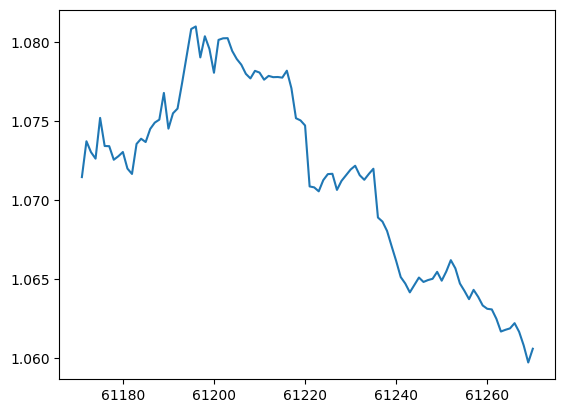

In [46]:
df['Close'].iloc[61171-start:61171+100-start].plot()

In [28]:
# Extract the specified range of data
subset = df['Close'].iloc[46136-start:46282-start]

# Find the 3 highest points and their indices
top_3_highest = subset.nlargest(3)
top_3_smallest = subset.nsmallest(3)

# Display the 3 highest points and their indices
print(top_3_highest, top_3_smallest)


46155    1.07333
46146    1.07286
46154    1.07274
Name: Close, dtype: float64 46255    1.03809
46254    1.03848
46274    1.03848
Name: Close, dtype: float64


In [109]:
for i in signal_indices[-15:]:
    print(i, df['Signal'].iloc[i])

4050 1
4088 -1
4128 1
4177 -1
4184 1
4291 1
4342 -1
4374 1
4432 1
4527 -1
4618 1
4684 1
4845 -1
4913 1
4984 -1


In [49]:
import pandas as pd
import os

data_dir = 'ohlc_data'
data_path = os.path.join(os.getcwd(), data_dir)
    

# List of all CSV files to merge
csv_files = [
    "10000_15000.csv", "15000_20000.csv", "1st_5000.csv",
    "20000_25000.csv", "25000_30000.csv", "30000_35000.csv",
    "35000_40000.csv", "40000_45000.csv", "45000_50000.csv",
    "50000_55000.csv", "5000_10000.csv", "55000_60000.csv",
    "60000_61938.csv"
]

# Initialize an empty list to store DataFrames
dataframes = []

# Read and append each CSV file to the list
for file in csv_files:
    df = pd.read_csv(os.path.join(data_path, file))
    dataframes.append(df)

# Concatenate all DataFrames vertically (stacking columns)
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged_data.csv", index=False)

print("All CSV files have been merged and saved as 'merged_data.csv'.")


All CSV files have been merged and saved as 'merged_data.csv'.


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Step 1: Load the merged data file
merged_data = pd.read_csv("merged_data.csv")

# Ensure the 'Date' column is parsed as datetime for proper plotting
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Step 2: Split data into chunks of 5000 rows
chunk_size = 5000
num_chunks = len(merged_data) // chunk_size + (1 if len(merged_data) % chunk_size != 0 else 0)

# Create output directory for charts
os.makedirs("charts", exist_ok=True)

# Step 3: Generate charts for each chunk
for i in range(num_chunks):
    # Slice the DataFrame for the current chunk
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(merged_data))
    chunk = merged_data.iloc[start_idx:end_idx]
    
    # Plot Close Prices
    plt.figure(figsize=(12, 6))
    plt.plot(chunk['Date'], chunk['Close'], label='Close Price', color='gray', linewidth=1)
    
    # Plot Buy Signals (Signal == 1)
    buy_signals = chunk[chunk['Signal'] == 1]
    plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy Signal', color='blue', marker='o', s=50)
    
    # Plot Sell Signals (Signal == -1)
    sell_signals = chunk[chunk['Signal'] == -1]
    plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell Signal', color='red', marker='o', s=50)
    
    # Add chart details
    plt.title(f"Close Prices and Signals (Rows {start_idx} to {end_idx - 1})", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Close Price", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    
    # Step 4: Save the chart
    chart_filename = f"charts/close_prices_signals_{start_idx}_{end_idx - 1}.png"
    plt.savefig(chart_filename)
    plt.close()

print(f"Charts for all chunks have been saved in the 'charts' directory.")


Charts for all chunks have been saved in the 'charts' directory.


Final Portfolio Value: $442258.32
Cumulative Return: 342.26%
Sharpe Ratio: -2.03
Maximum Drawdown: -7.26%


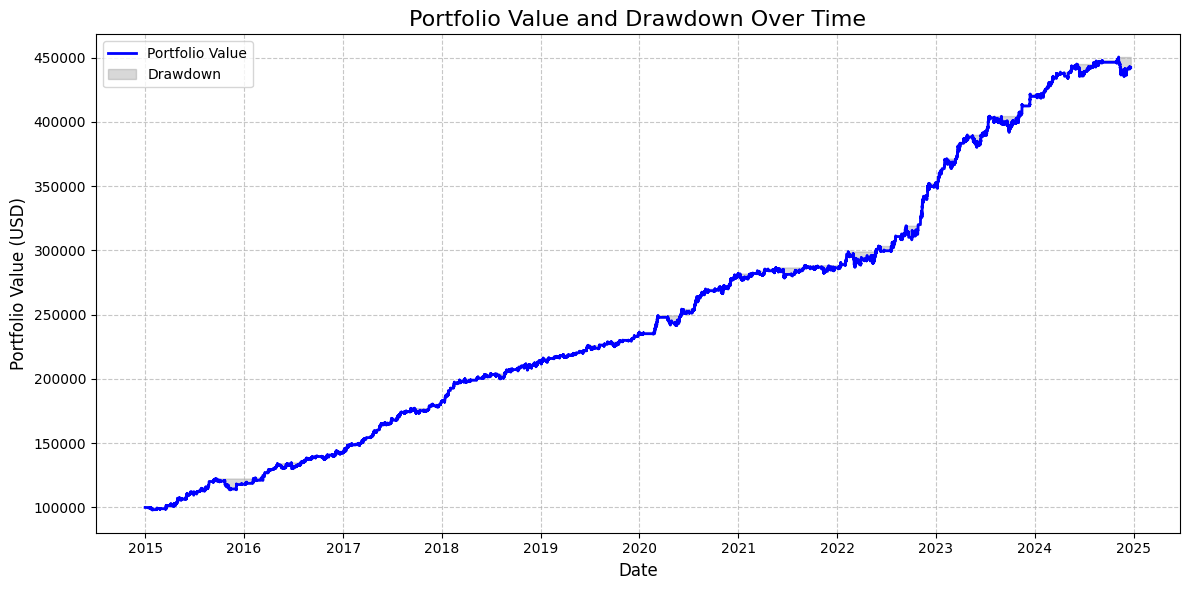

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = 'ohlc_data'
dataset = '0_61938.csv'
dataset_file = os.path.join(os.getcwd(), data_dir, dataset)
# Load the dataset
# data = pd.read_csv("merged_data.csv")
data = pd.read_csv(dataset_file)

# Ensure 'Date' column is parsed as datetime
data['Date'] = pd.to_datetime(data['Date'])

# Initialize Portfolio
starting_capital = 100000  # Starting capital in USD
cash = starting_capital  # Cash available
stock_holdings = 0  # Number of shares held
portfolio_values = []  # To track portfolio value over time
dates = []  # To track dates for plotting

# Simulate trading
for idx, row in data.iterrows():
    price = row['Close']  # Current stock price
    signal = row['Signal']  # Current signal (1, -1, or 0)

    # Handle Buy Signal
    if signal == 2:  # Buy
        shares_to_buy = cash // price  # Buy as many shares as possible
        cash -= shares_to_buy * price
        stock_holdings += shares_to_buy

    # Handle Sell Signal
    elif signal == 1:  # Sell
        cash += stock_holdings * price  # Sell all shares
        stock_holdings = 0

    # Calculate current portfolio value
    portfolio_value = cash + stock_holdings * price
    portfolio_values.append(portfolio_value)
    dates.append(row['Date'])

# Add the portfolio values to the DataFrame
data['Portfolio Value'] = portfolio_values

# Calculate Daily Returns
data['Daily Return'] = data['Portfolio Value'].pct_change()

# Sharpe Ratio
risk_free_rate = 0.03 / 252  # Convert annual risk-free rate to daily
excess_daily_return = data['Daily Return'] - risk_free_rate
sharpe_ratio = excess_daily_return.mean() / excess_daily_return.std() * np.sqrt(252)

# Drawdown
data['Peak'] = data['Portfolio Value'].cummax()
data['Drawdown'] = (data['Portfolio Value'] - data['Peak']) / data['Peak']
max_drawdown = data['Drawdown'].min()

# Cumulative Return
final_portfolio_value = portfolio_values[-1]
cumulative_return = (final_portfolio_value - starting_capital) / starting_capital

# Display Results
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Cumulative Return: {cumulative_return * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

# Plot Portfolio Performance
plt.figure(figsize=(12, 6))
plt.plot(dates, portfolio_values, label="Portfolio Value", color='blue', linewidth=2)
plt.fill_between(dates, portfolio_values, data['Peak'], color='gray', alpha=0.3, label='Drawdown')
plt.title("Portfolio Value and Drawdown Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (USD)", fontsize=12)
plt.grid(linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
df['Signal'].value_counts()

Signal
 0    61001
 1      485
-1      452
Name: count, dtype: int64

In [13]:
raw_data.to_csv('Cleaned_Signal_EURUSD_for_training.csv')